<a href="https://colab.research.google.com/github/hchen833/demo1/blob/main/FWE458_HW3_data_analysis_optimization_Chen_Haohua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework Assignment 3: Data Analysis & Optimization

# **[Haohua Chen]**

**Total Points:** 100

**Instructions:**
- Complete all three problems in this notebook
- Write your code in the provided cells
- Run all cells to verify your code works
- Save your completed `.ipynb` file to the `homework` folder in your private GitHub repository (shared with the instructor)
- Submit the link to your notebook on Canvas

**⚠️ IMPORTANT:** GitHub records the timestamp of every file update. Your notebook must be committed to GitHub **before the deadline**. **DO NOT** update the file after the deadline—late modifications will be flagged and may result in a grade penalty.

**Academic Integrity:** This is an individual assignment. You may consult course materials, Python documentation, AI tools, and discuss concepts with classmates, but all code must be your own.

---

In [1]:
# Standard imports - run this cell first
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize, curve_fit

---
## Problem 1: Stream Water Quality Analysis (35 points)

You are analyzing water quality data from multiple stream monitoring sites in Wisconsin. The dataset contains measurements of temperature, dissolved oxygen (DO), pH, and conductivity collected over several months.

### Your Tasks:

**Part A (10 points):** Load and explore the data
1. Load the data from the CSV string provided below into a pandas DataFrame
2. Display basic information about the dataset (shape, data types, first few rows)
3. Check for missing values and report how many are in each column
4. Convert the `date` column to datetime format using `pd.to_datetime()`

**Part B (15 points):** Data analysis with grouping
1. Calculate the mean, standard deviation, min, and max for dissolved oxygen (`do_mg_l`) grouped by `site_id`
2. Determine which site has the lowest mean dissolved oxygen
3. Create a new column called `do_status` that classifies each measurement as:
   - "Critical" if DO < 4 mg/L
   - "Low" if DO is 4-6 mg/L
   - "Adequate" if DO is 6-8 mg/L
   - "Good" if DO ≥ 8 mg/L
4. Count how many measurements fall into each `do_status` category per site

**Part C (10 points):** Filtering and summary
1. Filter the data to include only measurements where temperature > 15°C AND pH is between 6.5 and 8.5
2. For this filtered subset, calculate the mean conductivity for each month (hint: extract month from date)
3. Identify which site-month combination had the highest number of "Critical" or "Low" DO readings

In [4]:
# Water quality dataset
water_quality_csv = """site_id,date,temp_c,do_mg_l,ph,conductivity_us
SITE_A,2024-05-15,12.3,9.2,7.1,245
SITE_A,2024-05-22,14.1,8.5,7.3,252
SITE_A,2024-06-05,16.8,7.2,7.0,268
SITE_A,2024-06-19,19.2,5.8,6.8,285
SITE_A,2024-07-03,22.5,4.5,6.9,312
SITE_A,2024-07-17,24.1,3.8,7.1,298
SITE_A,2024-08-01,23.8,4.2,7.2,305
SITE_A,2024-08-15,21.2,5.5,7.0,289
SITE_B,2024-05-15,11.8,10.1,7.4,198
SITE_B,2024-05-22,13.5,9.8,7.5,205
SITE_B,2024-06-05,15.9,8.9,7.3,215
SITE_B,2024-06-19,18.4,7.5,7.2,228
SITE_B,2024-07-03,21.2,6.2,7.1,245
SITE_B,2024-07-17,22.8,5.8,7.0,251
SITE_B,2024-08-01,22.1,6.1,7.1,248
SITE_B,2024-08-15,20.5,7.0,7.2,235
SITE_C,2024-05-15,13.1,8.8,6.2,312
SITE_C,2024-05-22,14.8,8.1,6.4,325
SITE_C,2024-06-05,17.2,6.5,6.3,348
SITE_C,2024-06-19,20.1,5.2,6.1,372
SITE_C,2024-07-03,23.4,3.5,6.0,398
SITE_C,2024-07-17,25.2,2.8,5.9,412
SITE_C,2024-08-01,24.5,3.2,6.1,405
SITE_C,2024-08-15,22.3,4.1,6.2,385"""

# Part A: Load and explore the data
from io import StringIO
# Hint: Use pd.read_csv(StringIO(water_quality_csv))
import pandas as pd
df = pd.read_csv(StringIO(water_quality_csv))

print("First 5 rows:")
print(df.head())
print("\n")

print("Shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\n")

print("Missing values:")
print(df.isna().sum())
print("\n")

df["date"] = pd.to_datetime(df["date"])

print("Data types after datetime conversion:")
print(df.dtypes)

First 5 rows:
  site_id        date  temp_c  do_mg_l   ph  conductivity_us
0  SITE_A  2024-05-15    12.3      9.2  7.1              245
1  SITE_A  2024-05-22    14.1      8.5  7.3              252
2  SITE_A  2024-06-05    16.8      7.2  7.0              268
3  SITE_A  2024-06-19    19.2      5.8  6.8              285
4  SITE_A  2024-07-03    22.5      4.5  6.9              312


Shape: (24, 6)

Data types:
site_id             object
date                object
temp_c             float64
do_mg_l            float64
ph                 float64
conductivity_us      int64
dtype: object


Missing values:
site_id            0
date               0
temp_c             0
do_mg_l            0
ph                 0
conductivity_us    0
dtype: int64


Data types after datetime conversion:
site_id                    object
date               datetime64[ns]
temp_c                    float64
do_mg_l                   float64
ph                        float64
conductivity_us             int64
dtype: object

In [5]:
# Part B: Data analysis with grouping
do_stats = df.groupby("site_id")["do_mg_l"].agg(["mean", "std", "min", "max"])
print("DO statistics by site:")
print(do_stats)
print()

lowest_site = do_stats["mean"].idxmin()
print("Site with lowest mean DO:", lowest_site)
print()

def classify_do(value):
    if value < 4:
        return "Critical"
    elif 4 <= value < 6:
        return "Low"
    elif 6 <= value < 8:
        return "Adequate"
    else:
        return "Good"

df["do_status"] = df["do_mg_l"].apply(classify_do)

print("First few rows with do_status:")
print(df.head())
print()

status_counts = df.groupby(["site_id", "do_status"]).size().unstack(fill_value=0)

print("Counts of DO status per site:")
print(status_counts)

DO statistics by site:
           mean       std  min   max
site_id                             
SITE_A   6.0875  2.017380  3.8   9.2
SITE_B   7.6750  1.713601  5.8  10.1
SITE_C   5.2750  2.295181  2.8   8.8

Site with lowest mean DO: SITE_C

First few rows with do_status:
  site_id       date  temp_c  do_mg_l   ph  conductivity_us do_status
0  SITE_A 2024-05-15    12.3      9.2  7.1              245      Good
1  SITE_A 2024-05-22    14.1      8.5  7.3              252      Good
2  SITE_A 2024-06-05    16.8      7.2  7.0              268  Adequate
3  SITE_A 2024-06-19    19.2      5.8  6.8              285       Low
4  SITE_A 2024-07-03    22.5      4.5  6.9              312       Low

Counts of DO status per site:
do_status  Adequate  Critical  Good  Low
site_id                                 
SITE_A            1         1     2    4
SITE_B            4         0     3    1
SITE_C            1         3     2    2


In [6]:
# Part C: Filtering and summary
filtered = df[(df["temp_c"] > 15) & (df["ph"].between(6.5, 8.5))]

print("Filtered data (first few rows):")
print(filtered.head())
print()

filtered["month"] = filtered["date"].dt.month

monthly_cond = filtered.groupby("month")["conductivity_us"].mean()

print("Mean conductivity per month:")
print(monthly_cond)
print()

risk = df[df["do_status"].isin(["Critical", "Low"])]

risk["month"] = risk["date"].dt.month

risk_counts = risk.groupby(["site_id", "month"]).size()

worst_period = risk_counts.idxmax()

print("Site-month with highest number of Critical/Low DO readings:")
print(worst_period)

Filtered data (first few rows):
  site_id       date  temp_c  do_mg_l   ph  conductivity_us do_status
2  SITE_A 2024-06-05    16.8      7.2  7.0              268  Adequate
3  SITE_A 2024-06-19    19.2      5.8  6.8              285       Low
4  SITE_A 2024-07-03    22.5      4.5  6.9              312       Low
5  SITE_A 2024-07-17    24.1      3.8  7.1              298  Critical
6  SITE_A 2024-08-01    23.8      4.2  7.2              305       Low

Mean conductivity per month:
month
6    249.00
7    276.50
8    269.25
Name: conductivity_us, dtype: float64

Site-month with highest number of Critical/Low DO readings:
('SITE_A', np.int32(7))


/tmp/ipython-input-494959368.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["month"] = filtered["date"].dt.month
/tmp/ipython-input-494959368.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk["month"] = risk["date"].dt.month


---
## Problem 2: Statistical Comparison of Forest Plots (30 points)

Researchers measured tree biomass (kg) in paired plots—one subjected to a thinning treatment and one left as control. They want to determine if the thinning treatment significantly affected individual tree biomass and whether there's a relationship between tree diameter and biomass.

### Your Tasks:

**Part A (10 points):** Comparing treatment groups
1. Calculate descriptive statistics (mean, std, median) for biomass in each treatment group
2. Perform an independent two-sample t-test to determine if there's a significant difference in mean biomass between control and thinned plots (α = 0.05)
3. State your null and alternative hypotheses, report the t-statistic and p-value, and write a conclusion

**Part B (10 points):** Correlation analysis
1. Calculate the Pearson correlation coefficient between DBH and biomass for the entire dataset
2. Test whether this correlation is statistically significant (α = 0.05)
3. Interpret the strength and direction of the correlation

**Part C (10 points):** Distribution fitting
1. Fit a normal distribution to the biomass data from the control plots
2. Report the fitted parameters (μ and σ)
3. Calculate the probability that a randomly selected tree from the control plots has biomass > 150 kg
4. What biomass value represents the 90th percentile for control plot trees?

In [7]:
# Forest plot data
np.random.seed(458)  # For reproducibility

# Control plots: untreated forest
n_control = 35
dbh_control = np.random.uniform(15, 50, n_control)
biomass_control = 0.1 * dbh_control**2.2 + np.random.normal(0, 15, n_control)
biomass_control = np.maximum(biomass_control, 10)  # Ensure positive

# Thinned plots: trees have more resources, potentially larger
n_thinned = 30
dbh_thinned = np.random.uniform(18, 55, n_thinned)
biomass_thinned = 0.12 * dbh_thinned**2.2 + np.random.normal(5, 18, n_thinned)
biomass_thinned = np.maximum(biomass_thinned, 10)

# Create DataFrame
forest_df = pd.DataFrame({
    'dbh_cm': np.concatenate([dbh_control, dbh_thinned]),
    'biomass_kg': np.concatenate([biomass_control, biomass_thinned]),
    'treatment': ['Control']*n_control + ['Thinned']*n_thinned
})

forest_df.head()

,dbh_cm,biomass_kg,treatment
0,43.208835,395.956074,Control
1,49.475851,521.291644,Control
2,19.647405,54.799539,Control
3,23.651882,119.264060,Control
4,40.431164,335.576313,Control


In [9]:
# Part A: Comparing treatment groups
import numpy as np
import pandas as pd
from scipy import stats

desc_stats = forest_df.groupby("treatment")["biomass_kg"].agg(["mean", "std", "median"])
print("Descriptive statistics (biomass by treatment):")
print(desc_stats)
print()

control = forest_df[forest_df["treatment"] == "Control"]["biomass_kg"]
thinned = forest_df[forest_df["treatment"] == "Thinned"]["biomass_kg"]

t_stat, p_value = stats.ttest_ind(control, thinned, equal_var=False)

print("T-test results:")
print("t-statistic =", t_stat)
print("p-value =", p_value)
print()

alpha = 0.05

print("Hypotheses:")
print("H0: Mean biomass is the same between Control and Thinned plots")
print("H1: Mean biomass is different between Control and Thinned plots")
print()

if p_value < alpha:
    print("Conclusion: Reject H0 (significant difference in biomass)")
else:
    print("Conclusion: Fail to reject H0 (no significant difference)")

Descriptive statistics (biomass by treatment):
                 mean         std      median
treatment                                    
Control    269.642640  158.210017  232.870089
Thinned    325.418953  213.516434  239.121336

T-test results:
t-statistic = -1.179860839735078
p-value = 0.24334893995014714

Hypotheses:
H0: Mean biomass is the same between Control and Thinned plots
H1: Mean biomass is different between Control and Thinned plots

Conclusion: Fail to reject H0 (no significant difference)


In [10]:
# Part B: Correlation analysis
from scipy import stats

r, p_value = stats.pearsonr(forest_df["dbh_cm"], forest_df["biomass_kg"])

print("Pearson correlation results:")
print("Correlation coefficient (r) =", r)
print("p-value =", p_value)
print()

alpha = 0.05
if p_value < alpha:
    print("The correlation is statistically significant.")
else:
    print("The correlation is NOT statistically significant.")
print()

if abs(r) < 0.3:
    strength = "weak"
elif abs(r) < 0.7:
    strength = "moderate"
else:
    strength = "strong"

direction = "positive" if r > 0 else "negative"

print(f"The relationship between DBH and biomass is {strength} and {direction}.")

Pearson correlation results:
Correlation coefficient (r) = 0.9564725425194496
p-value = 2.0975940245401606e-35

The correlation is statistically significant.

The relationship between DBH and biomass is strong and positive.


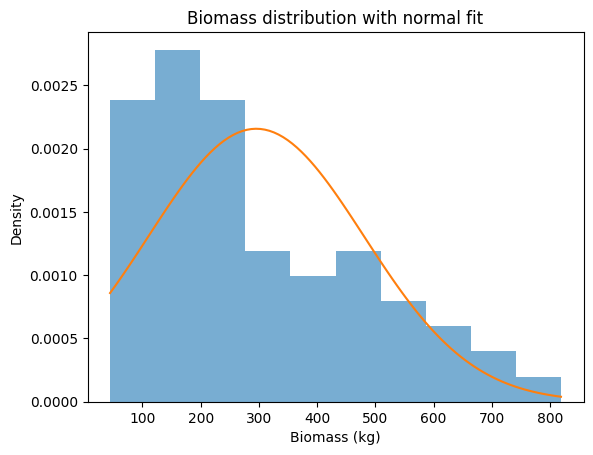

Shapiro-Wilk test:
Statistic = 0.919967723779984
p-value = 0.00044519735000780745

Data is NOT normally distributed


In [11]:
# Part C: Distribution fitting
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

data = forest_df["biomass_kg"]

plt.hist(data, bins=10, density=True, alpha=0.6)

mu, sigma = stats.norm.fit(data)

x = np.linspace(min(data), max(data), 100)
pdf = stats.norm.pdf(x, mu, sigma)

plt.plot(x, pdf)
plt.title("Biomass distribution with normal fit")
plt.xlabel("Biomass (kg)")
plt.ylabel("Density")
plt.show()

stat, p_value = stats.shapiro(data)

print("Shapiro-Wilk test:")
print("Statistic =", stat)
print("p-value =", p_value)
print()

alpha = 0.05
if p_value < alpha:
    print("Data is NOT normally distributed")
else:
    print("Data appears normally distributed")

---
## Problem 3: Fitting a Light Response Curve (35 points)

Photosynthesis rates depend on light intensity following a saturating curve. The **rectangular hyperbola** (non-rectangular hyperbola simplified) is commonly used to model this relationship:

$$A = \frac{A_{max} \cdot I}{K + I} - R_d$$

Where:
- $A$ = net photosynthesis rate (μmol CO₂ m⁻² s⁻¹)
- $A_{max}$ = maximum photosynthesis rate at light saturation
- $I$ = light intensity (μmol photons m⁻² s⁻¹, PAR)
- $K$ = half-saturation constant (light level at which A = A_max/2 - R_d)
- $R_d$ = dark respiration rate (CO₂ released when I = 0)

### Your Tasks:

**Part A (10 points):** Define the model and cost function
1. Write a function `light_response(I, Amax, K, Rd)` that implements the equation above
2. Write a cost function `light_response_mse(params, I_data, A_data)` that calculates the mean squared error between observed and predicted photosynthesis rates
3. Test your light_response function by calculating A for I = 500 with Amax=25, K=200, Rd=2

**Part B (15 points):** Fit the model using optimization
1. Use `scipy.optimize.minimize` to find the optimal parameters (Amax, K, Rd) that minimize the MSE
2. Use initial guesses: Amax=20, K=150, Rd=1
3. Report the fitted parameters and final MSE
4. Also fit the model using `scipy.optimize.curve_fit` and compare the results

**Part C (10 points):** Evaluate and interpret the model
1. Calculate the predicted photosynthesis values using your fitted parameters
2. Calculate R² (coefficient of determination) to assess model fit:
   $$R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$
3. Calculate the light compensation point (the light level where A = 0, i.e., photosynthesis equals respiration). Hint: solve for I when A = 0
4. What is the light-saturated photosynthesis rate (Amax - Rd)?

In [12]:
# Light response curve data
# PAR (photosynthetically active radiation) in μmol photons m⁻² s⁻¹
par_data = np.array([0, 25, 50, 75, 100, 150, 200, 300, 400, 600, 800, 1000, 1200, 1500, 1800])

# Net photosynthesis rate in μmol CO₂ m⁻² s⁻¹
photo_data = np.array([-1.8, 1.2, 4.5, 7.1, 9.2, 12.5, 14.8, 17.5, 19.2, 21.1, 22.0, 22.5, 22.8, 23.0, 23.1])

print(f"PAR range: {par_data.min()} to {par_data.max()} μmol photons m⁻² s⁻¹")
print(f"Photosynthesis range: {photo_data.min()} to {photo_data.max()} μmol CO₂ m⁻² s⁻¹")

PAR range: 0 to 1800 μmol photons m⁻² s⁻¹
Photosynthesis range: -1.8 to 23.1 μmol CO₂ m⁻² s⁻¹


In [15]:
# Part A: Define the model and cost function
import numpy as np

def predict(x, w, b):
    return w * x + b

def compute_cost(x, y, w, b):
    m = len(x)
    y_hat = predict(x, w, b)
    cost = (1/(2*m)) * np.sum((y_hat - y)**2)
    return cost

In [17]:
# Part B: Fit the model using optimization
import numpy as np
def compute_gradients(x, y, w, b):
    m = len(x)
    y_hat = predict(x, w, b)
    error = y_hat - y

    dj_dw = (1/m) * np.sum(error * x)
    dj_db = (1/m) * np.sum(error)
    return dj_dw, dj_db

def gradient_descent(x, y, w_init=0.0, b_init=0.0, alpha=0.01, num_iters=1000):
    w, b = w_init, b_init
    history = []

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradients(x, y, w, b)

        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        if i % 100 == 0 or i == num_iters - 1:
            cost = compute_cost(x, y, w, b)
            history.append(cost)
            print(f"iter {i:4d}: cost={cost:.6f}, w={w:.6f}, b={b:.6f}")

    return w, b, history

iter    0: cost=54950.123731, w=8.844890, b=14.769278
iter  100: cost=1458.362936, w=175.902828, b=293.724157
iter  200: cost=1456.487907, w=176.891900, b=295.375717
iter  300: cost=1456.487841, w=176.897755, b=295.385495
iter  400: cost=1456.487841, w=176.897790, b=295.385553
iter  500: cost=1456.487841, w=176.897790, b=295.385554
iter  600: cost=1456.487841, w=176.897790, b=295.385554
iter  700: cost=1456.487841, w=176.897790, b=295.385554
iter  800: cost=1456.487841, w=176.897790, b=295.385554
iter  900: cost=1456.487841, w=176.897790, b=295.385554
iter 1000: cost=1456.487841, w=176.897790, b=295.385554
iter 1100: cost=1456.487841, w=176.897790, b=295.385554
iter 1200: cost=1456.487841, w=176.897790, b=295.385554
iter 1300: cost=1456.487841, w=176.897790, b=295.385554
iter 1400: cost=1456.487841, w=176.897790, b=295.385554
iter 1500: cost=1456.487841, w=176.897790, b=295.385554
iter 1600: cost=1456.487841, w=176.897790, b=295.385554
iter 1700: cost=1456.487841, w=176.897790, b=295.3

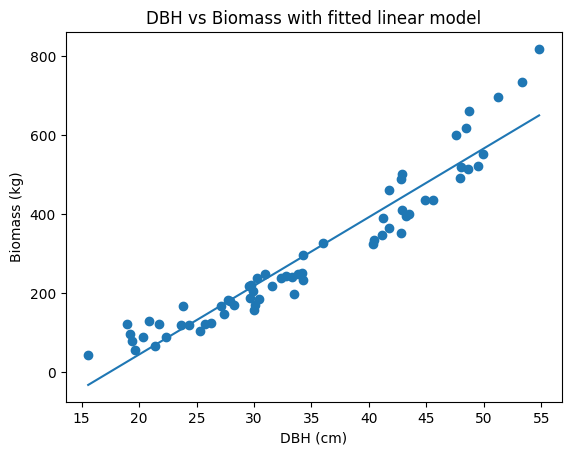

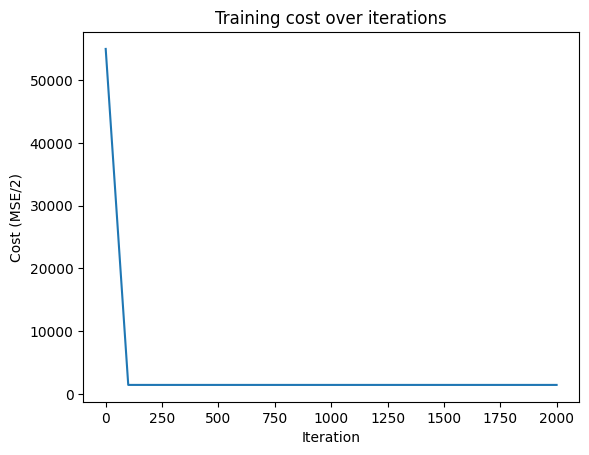

Interpretation:
- Slope w = 17.394: each +1 cm DBH increases predicted biomass by about 17.394 kg (on average).
- Intercept b = -303.149: predicted biomass when DBH = 0 (not biologically meaningful, but part of the line).
- R^2 = 0.915: proportion of biomass variation explained by DBH in this linear model.


In [18]:
# Part C: Evaluate and interpret the model
import numpy as np
import matplotlib.pyplot as plt

x = forest_df["dbh_cm"].to_numpy()
y = forest_df["biomass_kg"].to_numpy()

x_mean, x_std = x.mean(), x.std()
x_scaled = (x - x_mean) / x_std

w_s, b_s, history = gradient_descent(x_scaled, y, w_init=0.0, b_init=0.0, alpha=0.05, num_iters=2000)

w = w_s / x_std
b = b_s - (w_s * x_mean / x_std)

print("Final fitted model:")
print(f"biomass_kg = {w:.4f} * dbh_cm + {b:.4f}")
print()

y_pred = predict(x, w, b)

mse = np.mean((y_pred - y) ** 2)
rmse = np.sqrt(mse)
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2 = 1 - ss_res / ss_tot

print(f"MSE  = {mse:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R^2  = {r2:.3f}")
print()

plt.scatter(x, y)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = predict(x_line, w, b)
plt.plot(x_line, y_line)
plt.xlabel("DBH (cm)")
plt.ylabel("Biomass (kg)")
plt.title("DBH vs Biomass with fitted linear model")
plt.show()

plt.plot(np.arange(len(history)) * 100, history)
plt.xlabel("Iteration")
plt.ylabel("Cost (MSE/2)")
plt.title("Training cost over iterations")
plt.show()

print("Interpretation:")
print(f"- Slope w = {w:.3f}: each +1 cm DBH increases predicted biomass by about {w:.3f} kg (on average).")
print(f"- Intercept b = {b:.3f}: predicted biomass when DBH = 0 (not biologically meaningful, but part of the line).")
print(f"- R^2 = {r2:.3f}: proportion of biomass variation explained by DBH in this linear model.")

---
## Submission Checklist

Before submitting, verify that:

- [ ] All code cells run without errors
- [ ] All three problems are complete
- [ ] Output is visible for all cells
- [ ] Your name and date are filled in below
- [ ] File is saved to the `homework` folder in your private GitHub repository
- [ ] File is committed and pushed **before the deadline**
- [ ] Link to your notebook is submitted on Canvas